In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sys
ROOT = "../../"
sys.path.append(ROOT) # Add root directory to path

from src.utils.ClassifierModel import ClassifierModel
from src.utils.REPDataset import REPDataset, plot_perturbation_layers

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

import lpips

In [44]:
def gaussian_noise_perturbation(std, mean=0):
    def perturbation(data):
        noise = torch.randn_like(data) * std + mean
        return data + noise.to(data.device)
    return perturbation

def laplacian_noise_perturbation(scale, loc=0):
    def perturbation(data):
        noise = torch.distributions.Laplace(loc, scale).sample(data.shape)
        return data + noise.to(data.device)
    return perturbation

def lp_norm_perturbation(epsilon, p=2):
    def perturbation(data):
        perturbation = torch.randn_like(data)
        perturbation = epsilon * perturbation / perturbation.norm(p=p)
        return data + perturbation.to(data.device)
    return perturbation

def lpips_perturbation(net='vgg', std=1.0):
    """
    Applies a perturbation sampled from the LPIPS distribution.
    
    Args:
        net (str): The network to use for LPIPS ('alex', 'vgg', or 'squeeze').
        std (float): The standard deviation of the noise to be added.
    
    Returns:
        A function that takes a PyTorch tensor `data` and returns the perturbed tensor.
    """
    def perturbation(data):
        device = data.device  # Get the device of the input data
        loss_fn = lpips.LPIPS(net=net).to(device)  # Move the LPIPS model to the same device

        batch_size = data.shape[0]
        noise = std * torch.randn_like(data)
        perturbed_data = data + noise

        # Compute the LPIPS distance between the original data and the perturbed data
        lpips_dist = loss_fn(data, perturbed_data)

        # Sample from the LPIPS distribution
        sampled_lpips = torch.distributions.Normal(lpips_dist, 1).sample()

        # Scale the perturbed data based on the sampled LPIPS distance
        perturbed_data = data + (sampled_lpips.view(-1, 1, 1, 1) * noise)
  
        return perturbed_data.squeeze(1)
    
    return perturbation

In [52]:
mnist_trainset = datasets.MNIST(root=ROOT+"src/data", train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root=ROOT+"src/data", train=False, download=True, transform=ToTensor())

# Extract the data and labels from the MNIST train set
train_data = mnist_trainset.data.numpy()
train_labels = mnist_trainset.targets.numpy()

# Define the perturbation functions
perturbations = [
    gaussian_noise_perturbation(std=5),
    gaussian_noise_perturbation(std=10),
    laplacian_noise_perturbation(scale=5),
    laplacian_noise_perturbation(scale=10),
    lp_norm_perturbation(epsilon=50, p=2),
    lp_norm_perturbation(epsilon=100, p=2),
    lpips_perturbation(std=5),
    lpips_perturbation(std=10),
    lpips_perturbation(std=20),
]

# Set the number of training and validation examples
N_training_examples = 50000
N_validation_examples = 10000

# Set the random seed for reproducibility
random_seed = 1
np.random.seed(random_seed)

# Create indices for the train set
train_indices = np.arange(len(train_data))
np.random.shuffle(train_indices)  # Shuffle the indices randomly

# Split the indices into training and validation sets
training_indices = train_indices[:N_training_examples]
validation_indices = train_indices[N_training_examples:N_training_examples+N_validation_examples]

# Create an instance of the REPDataset for the train set
rep_trainset = REPDataset(train_data, train_labels, training_indices, train_indices=training_indices, 
                          test_indices=validation_indices, perturbations=perturbations, include_original=True, shuffle=False)
# Extract the data and labels from the MNIST test set
test_data = mnist_testset.data.numpy()
test_labels = mnist_testset.targets.numpy()

# Create indices for the test set
test_indices = np.arange(len(test_data))

# Create an instance of the REPDataset for the test set (without perturbations)
rep_testset = REPDataset(test_data, test_labels, test_indices, train_indices=[], 
                         test_indices=test_indices)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: c:\ProgramData\anaconda3\envs\REP\lib\site-packages\lpips\weights\v0.1\vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: c:\ProgramData\anaconda3\envs\REP\lib\site-packages\lpips\weights\v0.1\vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: c:\ProgramData\anaconda3\envs\REP\lib\site-packages\lpips\weights\v0.1\vgg.pth


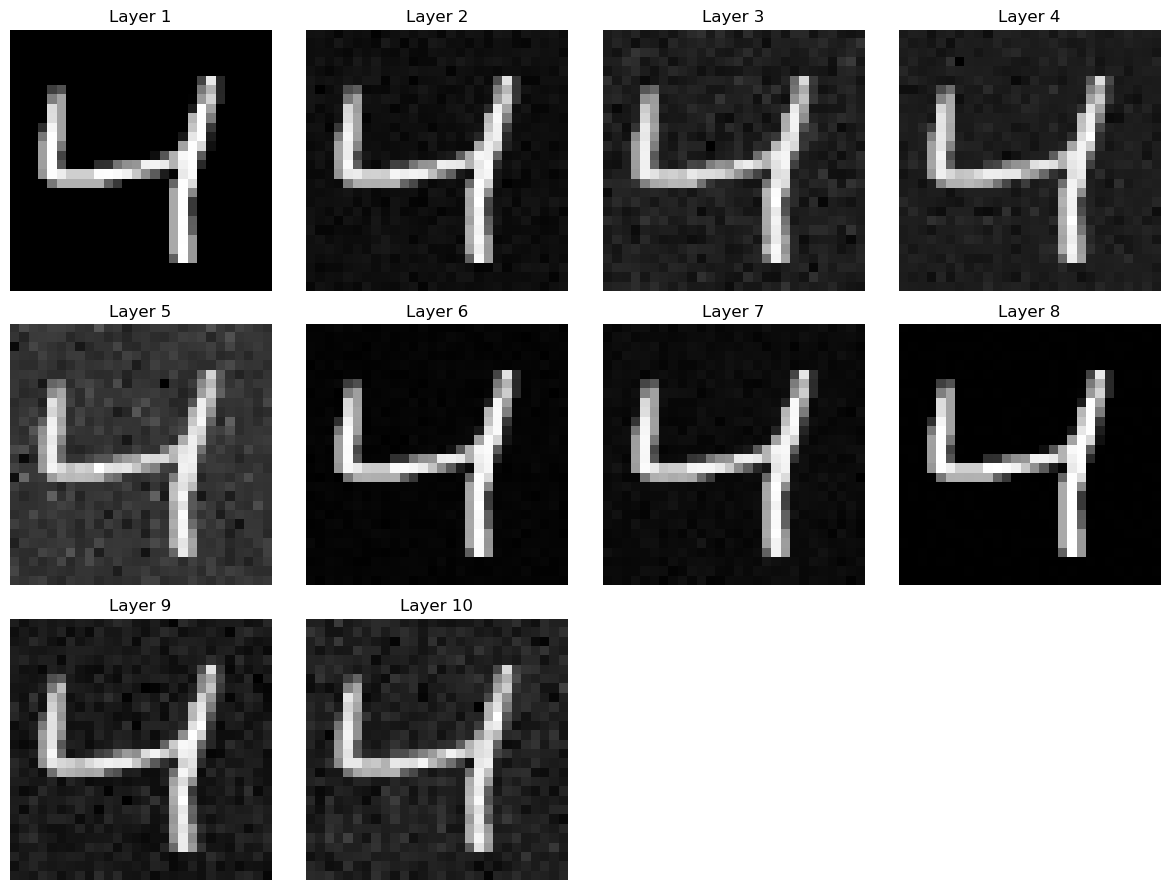

In [53]:
plot_perturbation_layers(rep_trainset, 2)

In [16]:
# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))

# your model will have length(channel_widths)-1 layers
channel_widths = [1, 64, 32] # must start with a 1 and be at least length--2
linear_sizes = [64, 32]
kernel = 3
model = ClassifierModel(channel_widths, linear_sizes, kernel, pool_fcn, num_perturbations=rep_trainset.multiplicity, num_classes=10)

In [17]:
config = {'lr': 1e-3,
          'n_epochs': 5,
          'batch_size': 64}
verbose = True # print metrics during training, False for no printing
model.train_model(rep_trainset, training_indices, validation_indices, config)

Epoch 1/5: (Train) Loss = 1.4958e+00, Acc = 0.4813, (Val) Loss = 1.1923e+00, Acc = 0.5839
Epoch 2/5: (Train) Loss = 7.1310e-01, Acc = 0.7578, (Val) Loss = 6.1118e-01, Acc = 0.7971
Epoch 3/5: (Train) Loss = 5.3436e-01, Acc = 0.8213, (Val) Loss = 8.7177e-01, Acc = 0.7329
Epoch 4/5: (Train) Loss = 4.5441e-01, Acc = 0.8487, (Val) Loss = 5.0983e-01, Acc = 0.8250
Epoch 5/5: (Train) Loss = 4.1068e-01, Acc = 0.8655, (Val) Loss = 5.9418e-01, Acc = 0.8120


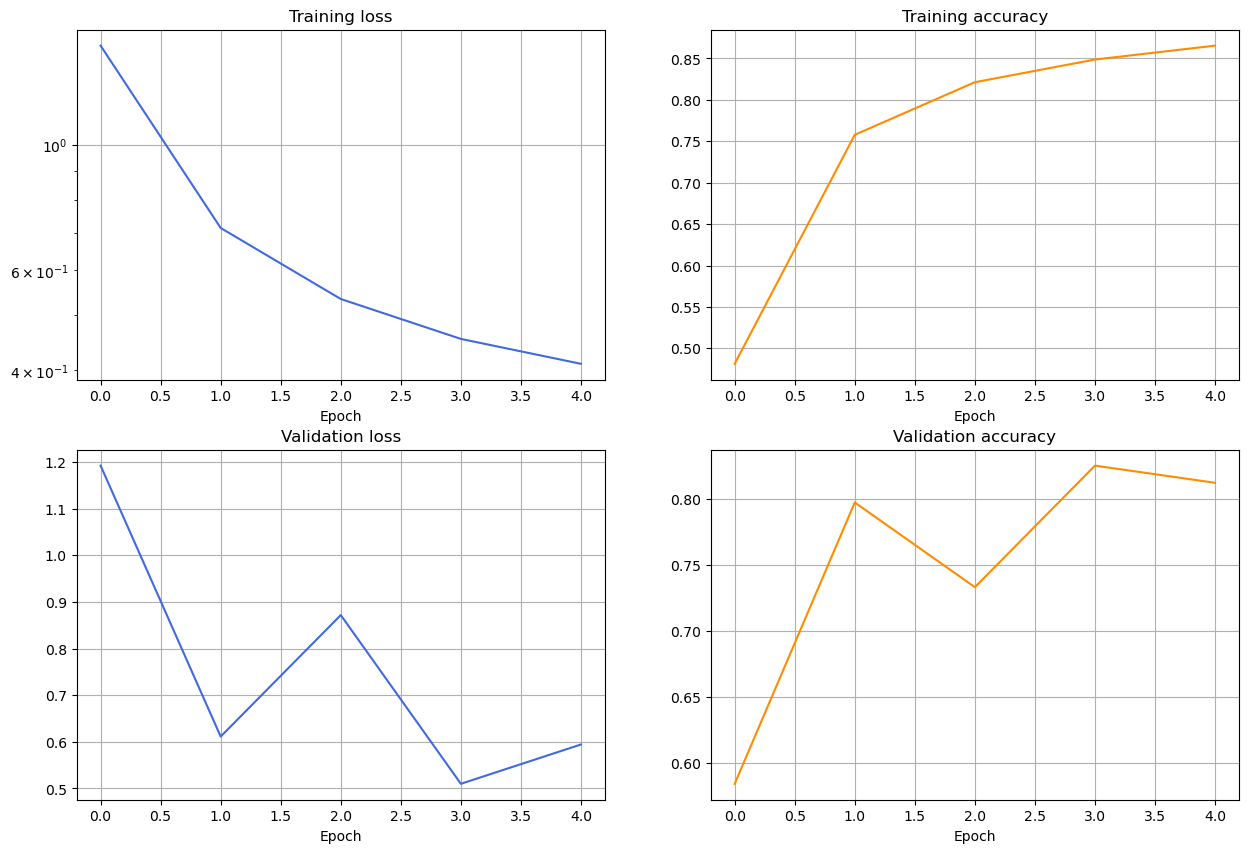

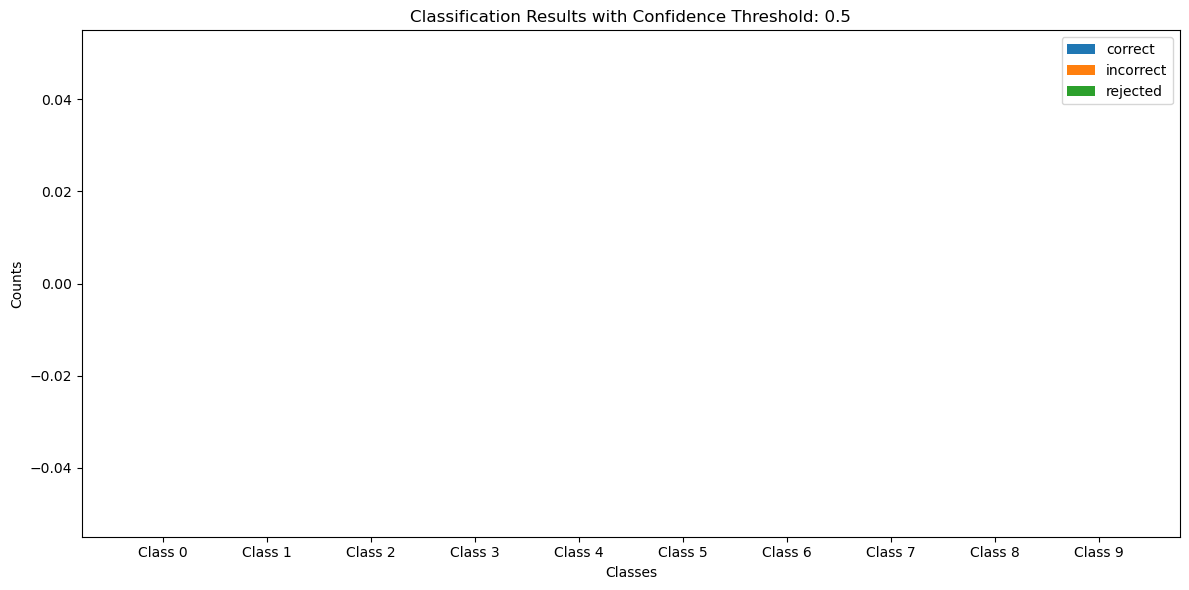

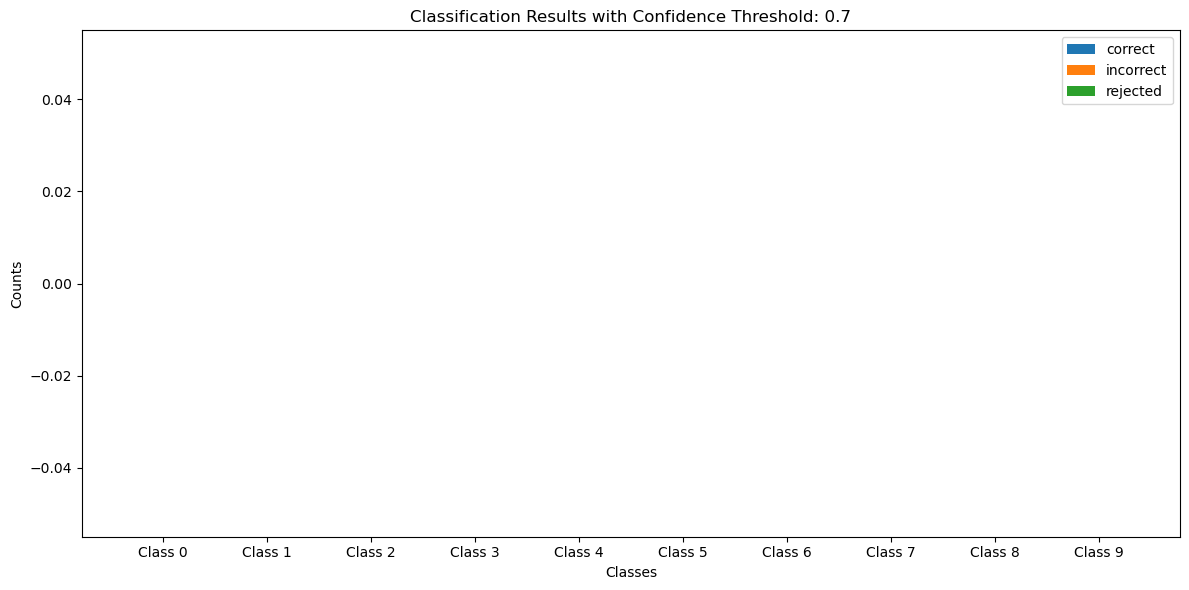

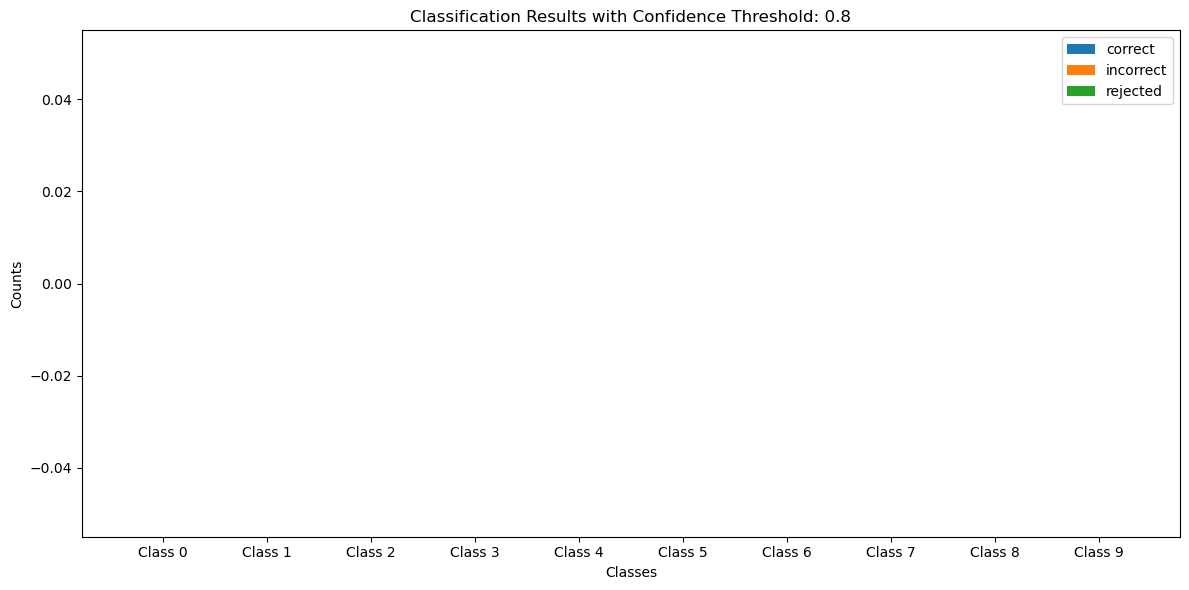

In [19]:
# plot training/validation loss and accuracy over training time
train_data = rep_trainset
test_data = rep_testset
model.plot_model_results()
model.plot_classification_results(test_data)
model.plot_classification_results(test_data, confidence_threshold=0.7)
model.plot_classification_results(test_data, confidence_threshold=0.8)


In [9]:
model_name = 'example_model'
model.save_model(ROOT + 'src/models/' + model_name + '.pt')